In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

In [4]:
batch_size = 128
z_size = 100

In [5]:
#data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
#import problem_unittests as tests
#import helper

%matplotlib inline

In [11]:
def get_dataloader(batch_size, image_size, data_dir=r'D:\moeimouto-faces\moeimouto-faces'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    transform = transforms.Compose([transforms.Resize((image_size, image_size)), 
                                transforms.ToTensor(), 
                                transforms.Normalize([0.5, 0.5, 0.5],
                                                    [0.5, 0.5, 0.5])])
                              
                                
    dataset=datasets.ImageFolder(data_dir,transform)
    dataloader=torch.utils.data.DataLoader(dataset=dataset,batch_size=batch_size)
    # TODO: Implement function and return a dataloader
    
    return dataloader


In [12]:
# Define function hyperparameters
 
img_size = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

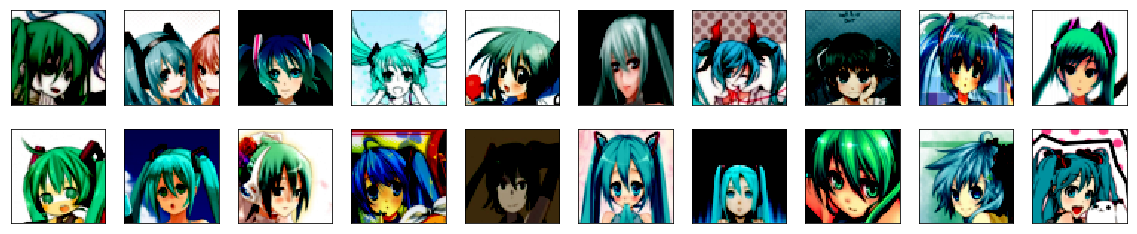

In [13]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [14]:
def init_weight(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    m.weight.data.normal_(0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    m.weight.data.normal_(0.1, 0.02)
    m.bias.data.fill_(0)

In [15]:
# Discriminator

# Probably a VGG16 or VGG19 for Simple Image Classification pretrained on ImageNet

class Discriminator(nn.Module):
    
    def __init__(self, inhw, c1_channels=64, c2_channels=128, c3_channels=256,
                 c4_channels=512, i_channels_in_2=True):
        '''
        The constructor method for the Discriminator class
        
        Arguments:
        - inhw : The number of 
        - c1_channels : the number of output channels from the
                        first Convolutional Layer [Default - 128]
                        
        - c2_channels : the number of output channels from the
                        second Convolutional Layer [Default - 256]
                        
        - c3_channels : the number of output channels from the
                        third Convolutional Layer [Default - 512]
        
        - i_channels_in_2 : Increase the number of channels by 2
                        in each layer.
        '''
        
        super().__init__()
        
        # Define the class variables
        self.c1_channels = c1_channels
        
        if i_channels_in_2:
            self.c2_channels = self.c1_channels * 2
            self.c3_channels = self.c2_channels * 2
            self.c4_channels = self.c3_channels * 2
        else:
            self.c2_channels = c2_channels
            self.c3_channels = c3_channels
            self.c4_channels = c4_channels
        
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=self.c1_channels,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False)
        
        self.conv2 = nn.Conv2d(in_channels=self.c1_channels,
                               out_channels=self.c2_channels,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False)
        
        self.bnorm2 = nn.BatchNorm2d(num_features=self.c2_channels)
        
        self.conv3 = nn.Conv2d(in_channels=self.c2_channels,
                               out_channels=self.c3_channels,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False)
        
        self.bnorm3 = nn.BatchNorm2d(num_features=self.c3_channels)
        
        self.conv4 = nn.Conv2d(in_channels=self.c3_channels,
                               out_channels=self.c4_channels,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False)
        
        self.bnorm4 = nn.BatchNorm2d(num_features=self.c4_channels)
        
        self.conv5 = nn.Conv2d(in_channels=self.c4_channels,
                               out_channels=1,
                               kernel_size=4,
                               padding=0,
                               stride=1,
                               bias=False)
        
        self.lrelu = nn.LeakyReLU(negative_slope=0.2)
        
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, img):
        '''
        The method for the forward pass in the network
        
        Arguments;
        - img : a torch.tensor that is of the shape N x C x H x W
                where, N - the batch_size
                       C - the number of channels
                       H - the height
                       W - the width
       
       Returns:
       - out : the output of the Discriminator 
               whether the passed image is real /fake
        '''
        
        #print (img.shape)
        
        batch_size = img.shape[0]
        
        x = self.lrelu(self.conv1(img))
        x = self.lrelu(self.bnorm2(self.conv2(x)))
        x = self.lrelu(self.bnorm3(self.conv3(x)))
        x = self.lrelu(self.bnorm4(self.conv4(x)))
        x = self.conv5(x)
        
        x = self.sigmoid(x)
        
        return x.view(-1, 1).squeeze()
      
    def out_shape(self, inp_dim, kernel_size=4, padding=1, stride=2):
        return ((inp_dim - kernel_size + (2 * padding)) // stride) + 1

In [16]:
class Generator(nn.Module):
    def __init__(self, ct1_channels=512, ct2_channels=256,
                 ct3_channels=128, ct4_channels=64, d_channels_in_2=False):
        
        '''
        The contructor class for the Generator
        
        Arguments:
        - zin_channels: ###
        
        - ct1_channels: The number of output channels for the
                        first ConvTranspose Layer. [Default - 1024]
        
        - ct2_channels: The number of putput channels for the
                        second ConvTranspose Layer. [Default - 512]
                        
        - ct3_channels: The number of putput channels for the
                        third ConvTranspose Layer. [Default - 256]
                        
        - ct4_channels: The number of putput channels for the
                        fourth ConvTranspose Layer. [Default - 128]
                        
        - d_channnels_in_2 : Decrease the number of channels 
                        by 2 times in each layer.
                        
        '''
        super().__init__()
        
        # Define the class variables
        self.ct1_channels = ct1_channels
        self.pheight = 4
        self.pwidth = 4
        
        if d_channels_in_2:
            self.ct2_channels = self.ct1_channels // 2
            self.ct3_channels = self.ct2_channels // 2
            self.ct4_channels = self.ct3_channels // 2
        else:
            self.ct2_channels = ct2_channels
            self.ct3_channels = ct3_channels
            self.ct4_channels = ct4_channels
        
        self.convt_0 = nn.ConvTranspose2d(in_channels=z_size,
                                          out_channels=self.ct1_channels,
                                          kernel_size=4,
                                          padding=0,
                                          stride=1,
                                          bias=False)
        
        self.bnorm0 = nn.BatchNorm2d(self.ct1_channels)
        
        self.convt_1 = nn.ConvTranspose2d(in_channels=self.ct1_channels,
                                          out_channels=self.ct2_channels,
                                          kernel_size=4,
                                          stride=2,
                                          padding=1,
                                          bias=False)
        
        self.bnorm1 = nn.BatchNorm2d(num_features=self.ct2_channels)
        
        self.convt_2 = nn.ConvTranspose2d(in_channels=self.ct2_channels,
                                          out_channels=self.ct3_channels,
                                          kernel_size=4,
                                          stride=2,
                                          padding=1,
                                          bias=False)
        
        self.bnorm2 = nn.BatchNorm2d(num_features=self.ct3_channels)
        
        self.convt_3 = nn.ConvTranspose2d(in_channels=self.ct3_channels,
                                          out_channels=self.ct4_channels,
                                          kernel_size=4,
                                          stride=2,
                                          padding=1,
                                          bias=False)
        
        self.bnorm3 = nn.BatchNorm2d(num_features=self.ct4_channels)
        
        self.convt_4 = nn.ConvTranspose2d(in_channels=self.ct4_channels,
                                          out_channels=3,
                                          kernel_size=4,
                                          stride=2,
                                          padding=1,
                                          bias=False)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, z):
        '''
        The method for the forward pass for the Generator
        
        Arguments:
        - z : the input random uniform vector sampled from uniform distribution
        
        Returns:
        - out : The output of the forward pass through the network
        '''
        
        # Project the input z and reshape
        x = self.relu(self.bnorm0(self.convt_0(z)))
        #print (x.shape)
        x = self.relu(self.bnorm1(self.convt_1(x)))
        x = self.relu(self.bnorm2(self.convt_2(x)))
        x = self.relu(self.bnorm3(self.convt_3(x)))
        out = self.tanh(self.convt_4(x))
        
        return out

In [17]:
dis = Discriminator(64).cuda()
dis.apply(init_weight)

gen = Generator().cuda()
gen.apply(init_weight)

Generator(
  (convt_0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bnorm0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt_1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bnorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt_2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt_3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt_4): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (relu): ReLU()
  (tanh): Tanh()
)

In [18]:
print (dis)
print ()
print (gen)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (lrelu): LeakyReLU(negative_slope=0.2)
  (sigmoid): Sigmoid()
)

Generator(
  (convt_0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bnorm0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convt_1): Con

In [19]:
criterion = nn.BCELoss()

In [20]:
# Optimizers
criterion = nn.BCELoss()
d_lr = 0.0002
g_lr = 0.0002

d_opt = optim.Adam(dis.parameters(), lr=d_lr, betas=[0.5, 0.999])
g_opt = optim.Adam(gen.parameters(), lr=g_lr, betas=[0.5, 0.999])

In [21]:
device=["cuda"]

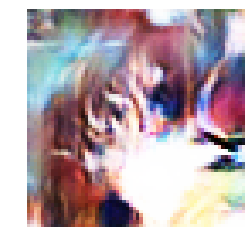

Epoch [    1 /    50] | d_loss: 0.7584 | g_loss: 1.6519


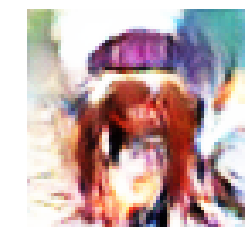

Epoch [    2 /    50] | d_loss: 0.7422 | g_loss: 1.8503


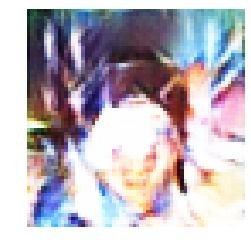

Epoch [    3 /    50] | d_loss: 0.7365 | g_loss: 1.7997


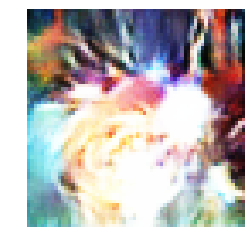

Epoch [    4 /    50] | d_loss: 0.7659 | g_loss: 1.5293


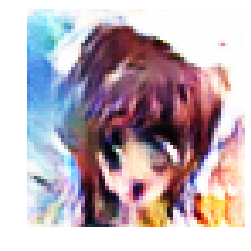

Epoch [    5 /    50] | d_loss: 0.7225 | g_loss: 2.1870


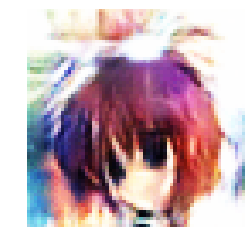

Epoch [    6 /    50] | d_loss: 0.7437 | g_loss: 1.7291


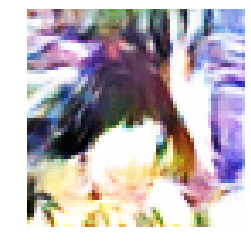

Epoch [    7 /    50] | d_loss: 0.7135 | g_loss: 1.9373


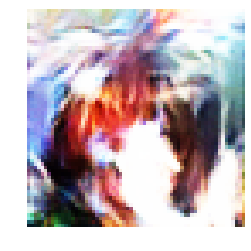

Epoch [    8 /    50] | d_loss: 0.6883 | g_loss: 2.3064


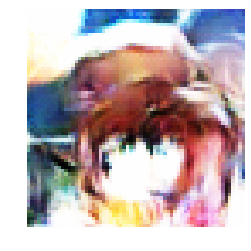

Epoch [    9 /    50] | d_loss: 0.7050 | g_loss: 2.1875


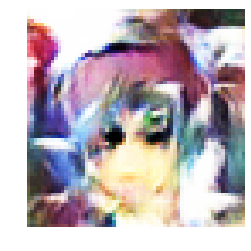

Epoch [   10 /    50] | d_loss: 0.6950 | g_loss: 2.4670


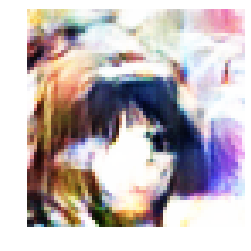

Epoch [   11 /    50] | d_loss: 0.7336 | g_loss: 1.9153


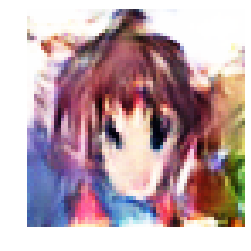

Epoch [   12 /    50] | d_loss: 0.7367 | g_loss: 2.1753


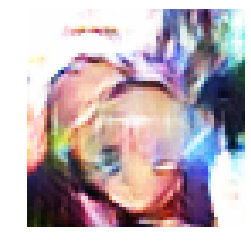

Epoch [   13 /    50] | d_loss: 0.7046 | g_loss: 2.0193


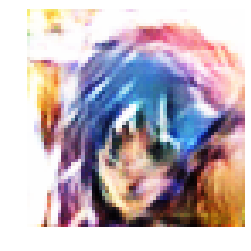

Epoch [   14 /    50] | d_loss: 0.6928 | g_loss: 2.3240


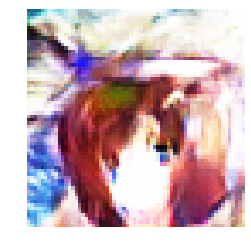

Epoch [   15 /    50] | d_loss: 0.7060 | g_loss: 2.4734


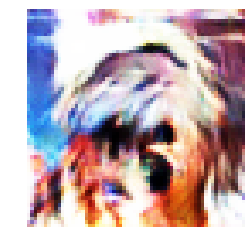

Epoch [   16 /    50] | d_loss: 0.6935 | g_loss: 2.1688


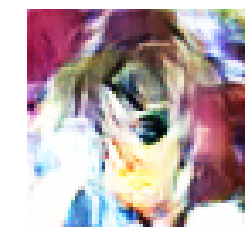

Epoch [   17 /    50] | d_loss: 0.6914 | g_loss: 2.5058


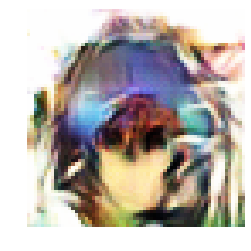

Epoch [   18 /    50] | d_loss: 0.7459 | g_loss: 1.6029


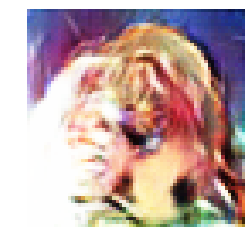

Epoch [   19 /    50] | d_loss: 0.8210 | g_loss: 1.4491


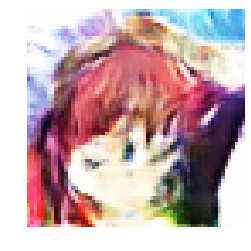

Epoch [   20 /    50] | d_loss: 0.7004 | g_loss: 2.0151


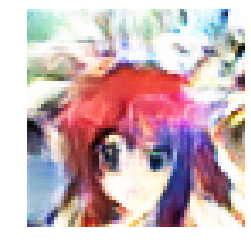

Epoch [   21 /    50] | d_loss: 0.7037 | g_loss: 2.4531


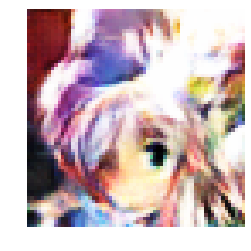

Epoch [   22 /    50] | d_loss: 0.6987 | g_loss: 2.0919


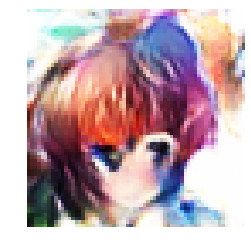

Epoch [   23 /    50] | d_loss: 0.6896 | g_loss: 1.9288


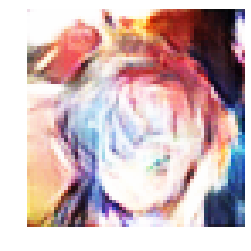

Epoch [   24 /    50] | d_loss: 0.6961 | g_loss: 2.2152


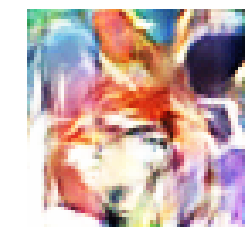

Epoch [   25 /    50] | d_loss: 0.7186 | g_loss: 1.9712


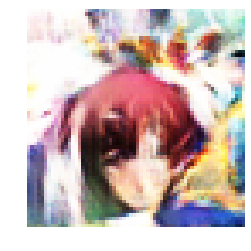

Epoch [   26 /    50] | d_loss: 0.7828 | g_loss: 2.0661


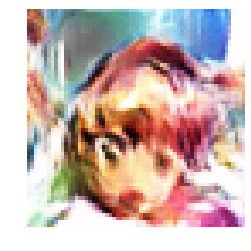

Epoch [   27 /    50] | d_loss: 0.7850 | g_loss: 1.9825


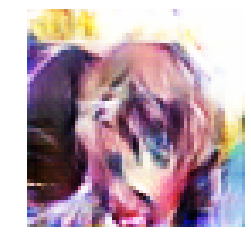

Epoch [   28 /    50] | d_loss: 0.7195 | g_loss: 2.1147


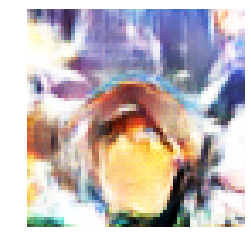

Epoch [   29 /    50] | d_loss: 0.7480 | g_loss: 2.2494


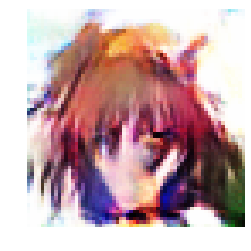

Epoch [   30 /    50] | d_loss: 0.7737 | g_loss: 1.7264


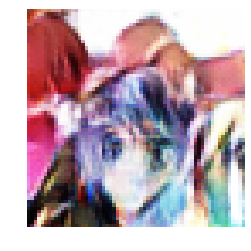

Epoch [   31 /    50] | d_loss: 0.6900 | g_loss: 2.1530


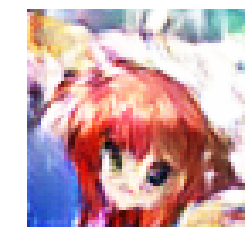

Epoch [   32 /    50] | d_loss: 0.7660 | g_loss: 1.5802


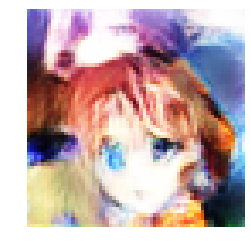

Epoch [   33 /    50] | d_loss: 0.6952 | g_loss: 2.1735


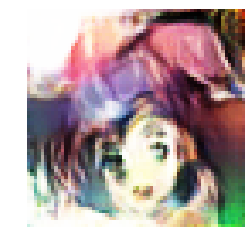

Epoch [   34 /    50] | d_loss: 0.7126 | g_loss: 1.6580


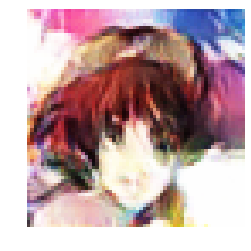

Epoch [   35 /    50] | d_loss: 0.6843 | g_loss: 2.3462


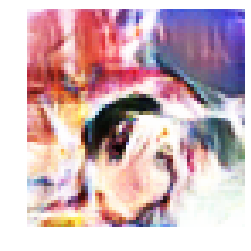

Epoch [   36 /    50] | d_loss: 0.7243 | g_loss: 2.2241


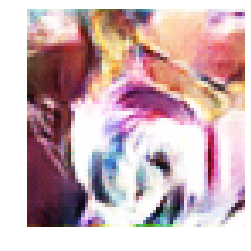

Epoch [   37 /    50] | d_loss: 0.7222 | g_loss: 2.2460


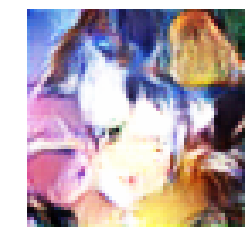

Epoch [   38 /    50] | d_loss: 0.7019 | g_loss: 2.0808


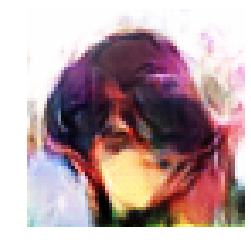

Epoch [   39 /    50] | d_loss: 0.7443 | g_loss: 1.9706


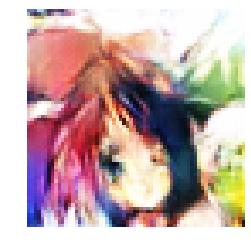

Epoch [   40 /    50] | d_loss: 1.8254 | g_loss: 0.7577


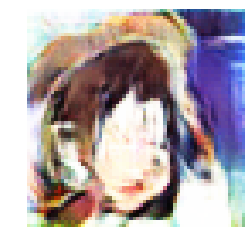

Epoch [   41 /    50] | d_loss: 0.8829 | g_loss: 1.5196


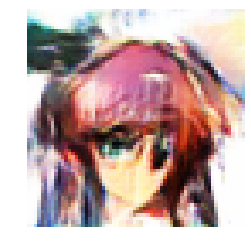

Epoch [   42 /    50] | d_loss: 0.7114 | g_loss: 2.1097


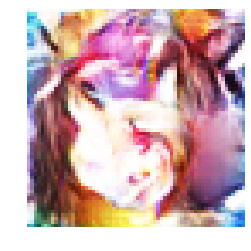

Epoch [   43 /    50] | d_loss: 1.0724 | g_loss: 1.5075


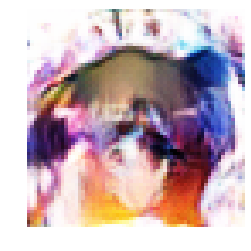

Epoch [   44 /    50] | d_loss: 0.7067 | g_loss: 1.9359


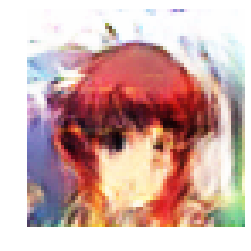

Epoch [   45 /    50] | d_loss: 0.8015 | g_loss: 2.4077


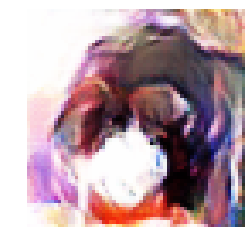

Epoch [   46 /    50] | d_loss: 0.6861 | g_loss: 2.3050


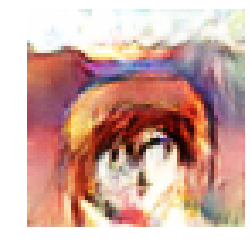

Epoch [   47 /    50] | d_loss: 0.7015 | g_loss: 2.6921


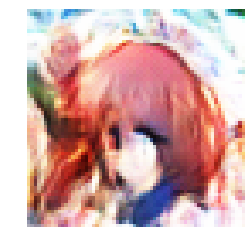

Epoch [   48 /    50] | d_loss: 0.6890 | g_loss: 2.5928


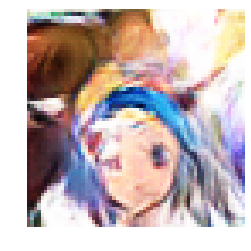

Epoch [   49 /    50] | d_loss: 0.6903 | g_loss: 2.1528


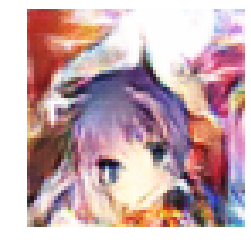

Epoch [   50 /    50] | d_loss: 0.7089 | g_loss: 2.0892
[INFO] Training Completed successfully!


SyntaxError: 'return' outside function (<ipython-input-23-ef316f57e4e6>, line 91)

In [23]:
# Train loop

p_every = 300
t_every = 1
e_every = 1
s_every = 1
epochs = 50

real_label = 0.9
fake_label = 0.1

train_losses = []
eval_losses = []
samples=[]
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
fixed_z = fixed_z.cuda()

for e in range(epochs):
    
    td_loss = 0
    tg_loss = 0
    
    for batch_i, (real_images, _) in enumerate(celeba_train_loader):
        
        real_images = real_images.cuda()
        
        batch_size = real_images.size(0)

        #### Train the Discriminator ####

        d_opt.zero_grad()
		
        d_real = dis(real_images)
        
        label = torch.full((batch_size,), real_label, device='cuda')
        
        r_loss = criterion(d_real,label)
        r_loss.backward()


        z = torch.randn(batch_size, z_size, 1, 1, device='cuda')

        fake_images = gen(z)
        
        label.fill_(fake_label)
        
        d_fake = dis(fake_images.detach())
        
        f_loss = criterion(d_fake,label)
        f_loss.backward()

        d_loss = r_loss + f_loss

        d_opt.step()


        #### Train the Generator ####
        g_opt.zero_grad()
        
        label.fill_(real_label)
        
        d_fake2 = dis(fake_images)
        
        g_loss = criterion(d_fake2, label)
        g_loss.backward()
		
        g_opt.step()
        
        if batch_i % p_every == 0:
          noise = torch.randn(1, 100, 1, 1, device='cuda')
          out = gen(noise)
          out = out.detach().cpu().squeeze(0).transpose(0, 1).transpose(1, 2).numpy()
          out = out * (0.5, 0.5, 0.5)
          out += (0.5, 0.5, 0.5)
          plt.axis('off')
          plt.imshow(out)
          plt.show()
          print ('Epoch [{:5d} / {:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'. \
                    format(e+1, epochs, d_loss, g_loss))
            
train_losses.append([d_loss, g_loss])
    

  
        
print ('[INFO] Training Completed successfully!')
    
    # finally return losses
return train_losses

    # Save training generator samples
 
                


## Load the pretrained model

In [34]:
torch.save(gen.state_dict(),'anime_face_generator.pt')

In [0]:
gen.load_state_dict(torch.load('anime_face_generator.pt'))

## Use the Generator to create some random images

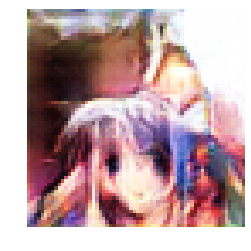

In [33]:
noise = torch.randn(1, 100, 1, 1, device='cuda')
out = gen(noise)
out = out.detach().cpu().squeeze(0).transpose(0, 1).transpose(1, 2).numpy()
out = out * (0.5, 0.5, 0.5)
out += (0.5, 0.5, 0.5)
plt.axis('off')
plt.imshow(out)
plt.show()

In [28]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [0]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])

## View the Generated Samples

In [0]:
def view_samples(images):
  if type(images) == torch.tensor:
    images = images.cpu().numpy()
    
  fig, axes = plt.subplots(figsize=(30, 30), nrows=8, ncols=8, sharey=True, sharex=True)
  
  for ax, img in zip(axes.flatten(), images):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.imshow(img)

In [0]:
ff = f.detach().cpu().transpose(1, 2).transpose(2, 3).numpy()
ff2 = inputs.detach().cpu().transpose(1, 2).transpose(2, 3).numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

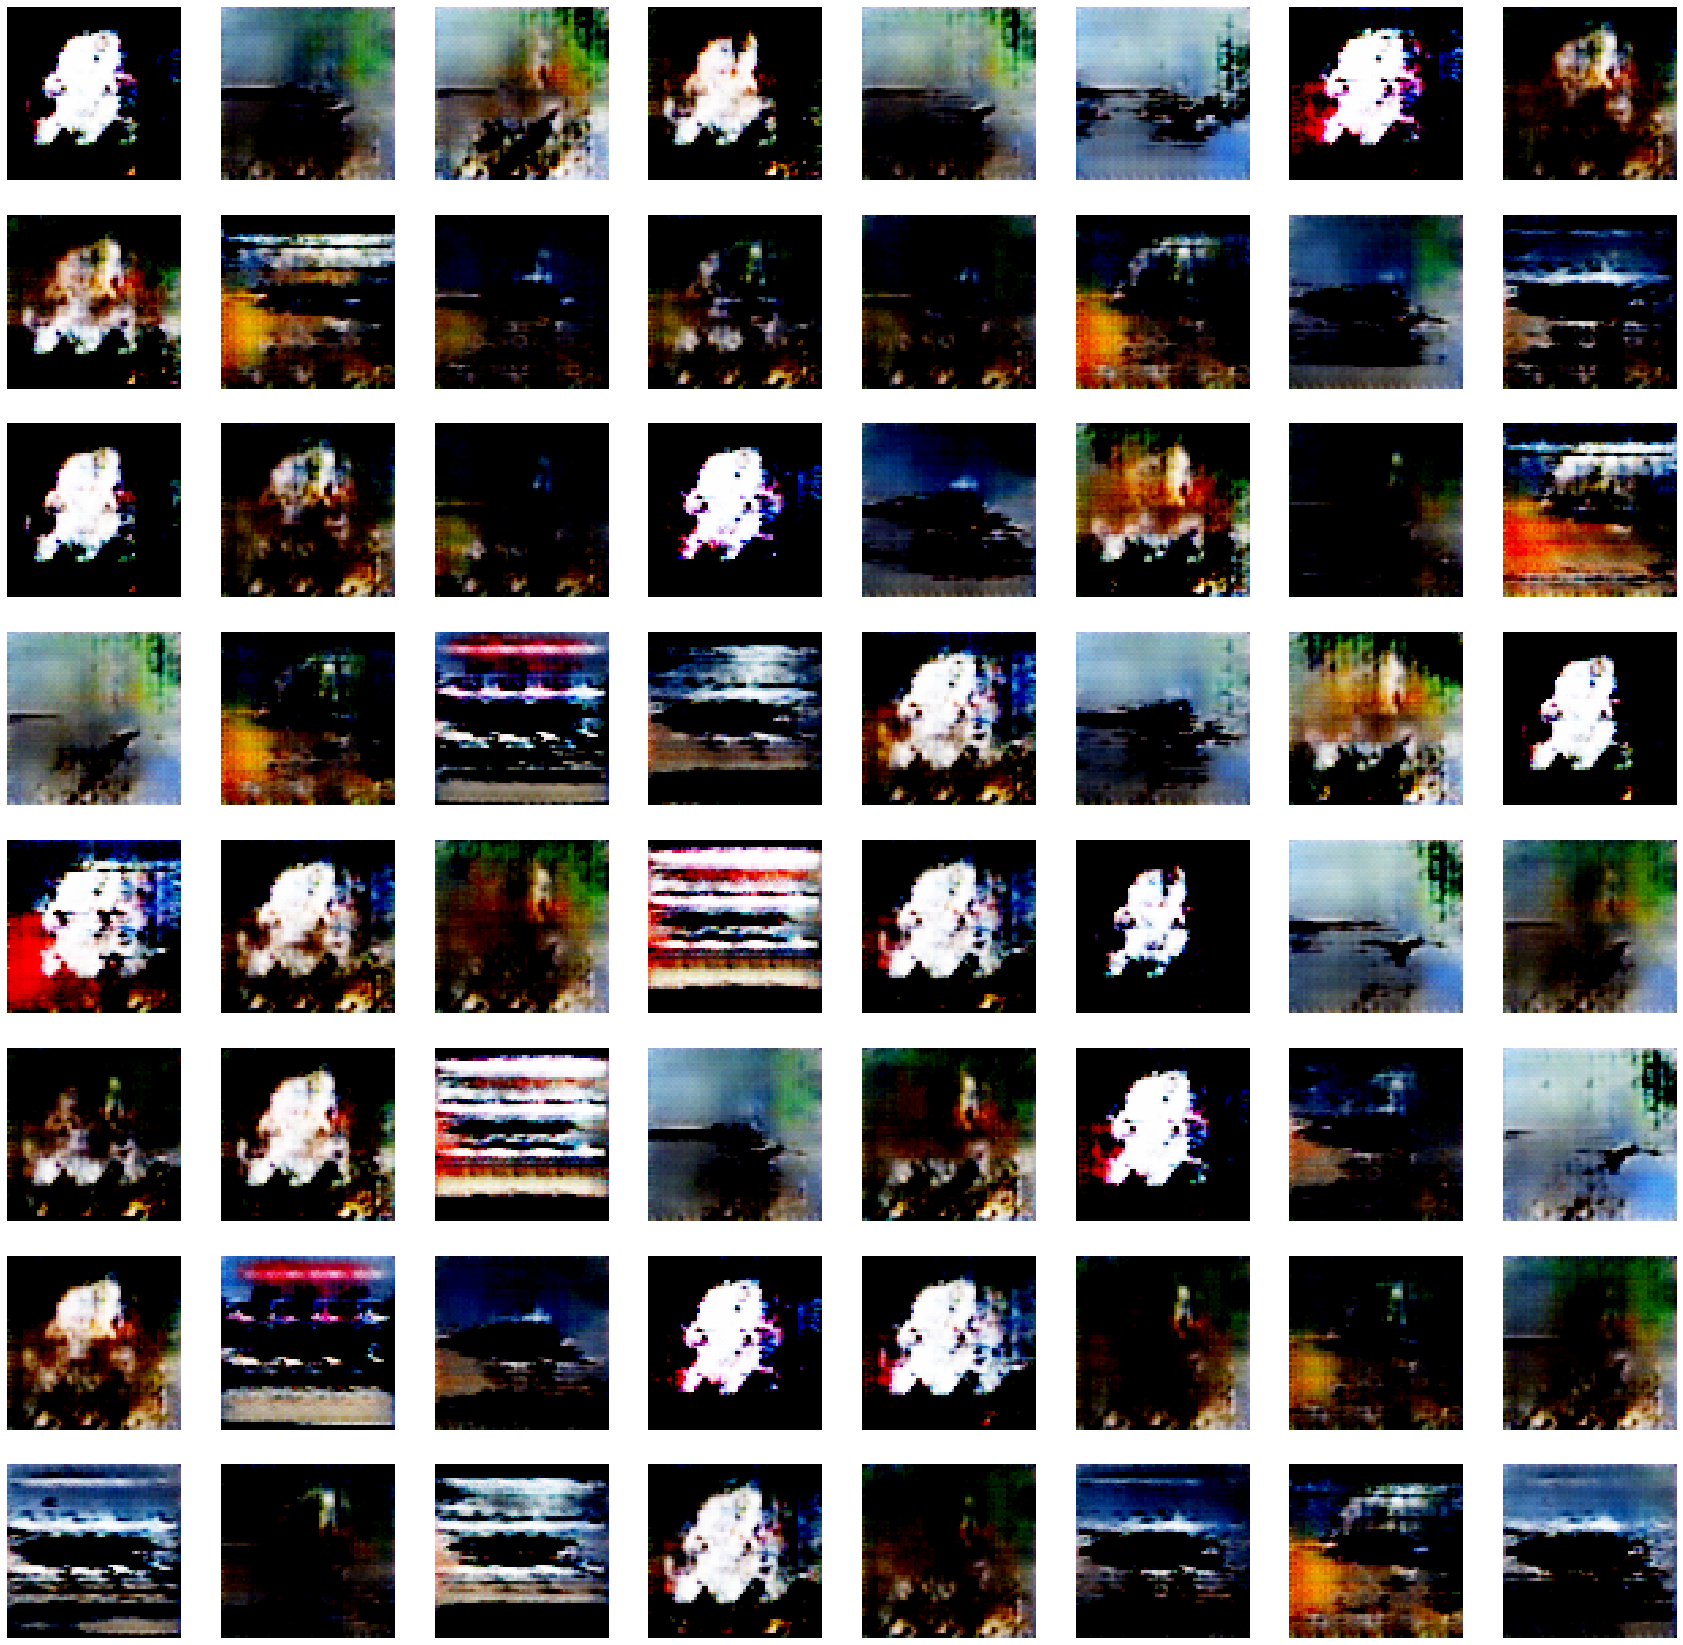

In [0]:
#view_samples(ff)
view_samples(ff)

## Check the Discriminator and the Generator Loss

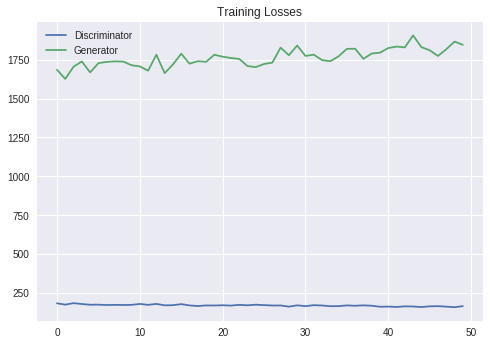

In [0]:
fig, ax = plt.subplots()
losses = np.array(train_losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title('Training Losses')
plt.legend()
plt.show()

## Save the models

In [0]:
d_ckpt = {
    'model_state_dict' : D.state_dict(),
    'opt_state_dict' : d_opt.state_dict()
}

g_ckpt = {
    'model_state_dict' : G.state_dict(),
    'opt_state_dict' : g_opt.state_dict()
}

In [0]:
torch.save(d_ckpt, 'd_ckpt.pth')
torch.save(g_ckpt, 'g_ckpt.pth')